# DKASC_爱丽丝泉_LSTM

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\Research Project\DKASC, Alice Springs


In [4]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation',
 '96-Site_DKA-MasterMeter1',
 'Alice_SpringsLSTM.ipynb',
 'Alice_SpringsSVM.ipynb',
 'Alice_Springs_2016-2020',
 'Alice_Springs数据集筛选提取.ipynb',
 'Alice_Springs深度神经网络-WDWDR.ipynb',
 'Alice_Springs深度神经网络.ipynb',
 'Dataset',
 'Predict',
 'Program backups',
 'temp',
 '笔记.ipynb']

In [5]:
os.chdir("./Dataset/")

In [6]:
os.listdir()

['testdata.csv',
 'test_1A.csv',
 'traindata.csv',
 'train_1A.csv',
 '测试集8个站点.csv',
 '训练集8个站点.csv']

In [7]:
train = pd.read_csv('train_1A.csv')
test = pd.read_csv('test_1A.csv')

In [8]:
#查看输入数据维度
print(train.shape)
print(test.shape)

(141428, 14)
(26091, 14)


In [9]:
train.head(5)

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [10]:
test.head(5)

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020,1,1,0,0,29.685360,21.727171,1.360221,1.191879,33.216167,0.0,2.958199,0.524153,0.0
1,2020,1,1,0,5,29.559967,21.878902,1.532208,1.460944,33.254341,0.0,3.288470,0.764565,0.0
2,2020,1,1,0,10,29.530006,21.859453,1.186835,1.118219,33.302616,0.0,3.253541,0.725652,0.0
3,2020,1,1,0,15,29.474438,21.897285,1.017349,0.824890,33.337837,0.0,3.260514,0.706365,0.0
4,2020,1,1,0,20,29.365288,22.085625,1.323369,1.175776,33.375069,0.0,3.148183,0.694154,0.0


# 数据预处理训练集去异常值

In [11]:
#使用df.isnull().sum()来获得与行数None和NaN值。
train.isnull().sum()

Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [12]:
test.isnull().sum()

Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [13]:
# #训练集去掉全是空值的行和列    #axis=0, how='any', thresh=None, subset=None, inplace=False)
# # detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# # for i in detectioncolumns:
# train.dropna(axis="index",how='any' , inplace=True)  #删除掉全是空值的行
# # train.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列


# test.dropna(axis="index", how='any', inplace=True)  #删除掉全是空值的行
# # test.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列

In [14]:
# #填补缺失值为均值
# #train.ffill({"RGT":train['RGT'].mean()})
# detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# for i in detectioncolumns:
#     replace_NA=train[i].mean()
#     train[i].fillna(replace_NA,inplace=True)
# #去除测试集空值
# for i in detectioncolumns:
#     replace_NA=test[i].mean()
#     test[i].fillna(replace_NA,inplace=True)


In [15]:
#去除 WD，WDR 特征
train=train[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'RGT', 'RDT', '1A Trina_power']]
print("查看训练集\n",train.head())
test=test[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR','RGT', 'RDT', '1A Trina_power']]
print("查看测试集\n",test.head())

查看训练集
    Year  Month  Day  Hour  Minutes        WTC        WRH        GHR  \
0  2018      1   19    18       30  26.243799  50.889774  71.416481   
1  2018      1   19    18       35  26.641783  49.539795  77.177094   
2  2018      1   19    18       40  26.654078  53.414265  78.373489   
3  2018      1   19    18       45  26.439108  55.582245  78.022881   
4  2018      1   19    18       50  26.479477  56.173820  82.106972   

         DHR        RGT        RDT  1A Trina_power  
0  67.523544  65.268631  59.278999        0.318600  
1  71.776718  72.546944  63.134579        0.328800  
2  69.008316  76.711456  65.430550        0.334200  
3  67.560181  80.445709  66.812790        0.333133  
4  73.004196  83.035919  69.054459        0.332400  
查看测试集
    Year  Month  Day  Hour  Minutes        WTC        WRH       GHR       DHR  \
0  2020      1    1     0        0  29.685360  21.727171  1.360221  1.191879   
1  2020      1    1     0        5  29.559967  21.878902  1.532208  1.460944   
2

In [16]:
train.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [17]:
test.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [18]:
train.head()

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,RGT,RDT,1A Trina_power
0,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,65.268631,59.278999,0.318600
1,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,72.546944,63.134579,0.328800
2,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,76.711456,65.430550,0.334200
3,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,80.445709,66.812790,0.333133
4,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,83.035919,69.054459,0.332400


In [19]:
test.head()

,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,RGT,RDT,1A Trina_power
0,2020,1,1,0,0,29.685360,21.727171,1.360221,1.191879,2.958199,0.524153,0.0
1,2020,1,1,0,5,29.559967,21.878902,1.532208,1.460944,3.288470,0.764565,0.0
2,2020,1,1,0,10,29.530006,21.859453,1.186835,1.118219,3.253541,0.725652,0.0
3,2020,1,1,0,15,29.474438,21.897285,1.017349,0.824890,3.260514,0.706365,0.0
4,2020,1,1,0,20,29.365288,22.085625,1.323369,1.175776,3.148183,0.694154,0.0


构建序列

In [20]:
train.shape[1]

12

In [21]:
print(list(train))

['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR', 'RGT', 'RDT', '1A Trina_power']


# 构建序列模型

In [22]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     n_vars = 1 if type(data) is list else data.shape[1]
    n_vars = list(data)
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j) )for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
train1 = series_to_supervised(train,1,1)
test1 = series_to_supervised(test,1,1)

In [24]:
train1.columns

Index(['Year(t-1)', 'Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)',
       'WTC(t-1)', 'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)', 'RGT(t-1)', 'RDT(t-1)',
       '1A Trina_power(t-1)', 'Year(t)', 'Month(t)', 'Day(t)', 'Hour(t)',
       'Minutes(t)', 'WTC(t)', 'WRH(t)', 'GHR(t)', 'DHR(t)', 'RGT(t)',
       'RDT(t)', '1A Trina_power(t)'],
      dtype='object')

In [25]:
test1.columns

Index(['Year(t-1)', 'Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)',
       'WTC(t-1)', 'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)', 'RGT(t-1)', 'RDT(t-1)',
       '1A Trina_power(t-1)', 'Year(t)', 'Month(t)', 'Day(t)', 'Hour(t)',
       'Minutes(t)', 'WTC(t)', 'WRH(t)', 'GHR(t)', 'DHR(t)', 'RGT(t)',
       'RDT(t)', '1A Trina_power(t)'],
      dtype='object')

In [26]:
train1.drop(train1.columns[[0,12]],axis=1,inplace=True)

test1.drop(test1.columns[[0,12]],axis=1,inplace=True)

归一化

In [27]:
train1 = train1.values
train1 = train1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
train1 = scaler.fit_transform(train1)

test1 = test1.values
test1 = test1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
test1 = scaler.fit_transform(test1)

inds = np.arange(train1.shape[0])
train1_inds = inds[0:int(train1.shape[0]*0.8)]
eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]


train_X, train_y = train1[train1_inds,:-1], train1[train1_inds,-1:]
eval_X,eval_y = train1[eval1_inds,:-1], train1[eval1_inds,-1:]
test_X, test_y = test1[:, :-1], test1[:,-1:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
eval_X = eval_X.reshape((eval_X.shape[0],1,eval_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,eval_X.shape,eval_y.shape, test_X.shape, test_y.shape)

(113141, 1, 21) (113141, 1) (28286, 1, 21) (28286, 1) (26090, 1, 21) (26090, 1)


In [28]:
print(train1)

[[0.         0.6        0.7826087  ... 0.05650019 0.21471684 0.0411343 ]
 [0.         0.6        0.7826087  ... 0.05974475 0.22252293 0.04175143]
 [0.         0.6        0.7826087  ... 0.0626541  0.22722241 0.04162953]
 ...
 [1.         1.0000001  1.         ... 0.00221545 0.00174257 0.00355801]
 [1.         1.0000001  1.         ... 0.00198068 0.00122578 0.00355801]
 [1.         1.0000001  1.         ... 0.00217768 0.00139605 0.00355801]]


In [29]:
print(train_X)

[[[0.         0.6        0.7826087  ... 0.25558963 0.05650019 0.21471684]]

 [[0.         0.6        0.7826087  ... 0.24573164 0.05974475 0.22252293]]

 [[0.         0.6        0.7826087  ... 0.24057497 0.0626541  0.22722241]]

 ...

 [[0.27272728 0.26666668 0.9130435  ... 0.00807928 0.00288026 0.0033492 ]]

 [[0.27272728 0.26666668 0.9130435  ... 0.00600753 0.00263039 0.00251978]]

 [[0.27272728 0.26666668 0.9130435  ... 0.00304714 0.00241778 0.00170415]]]


In [30]:
print(train_y)

[[0.0411343 ]
 [0.04175143]
 [0.04162953]
 ...
 [0.00355801]
 [0.00355801]
 [0.00355801]]


# LSTM model1

In [31]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

Train on 113141 samples, validate on 26090 samples
Epoch 1/50
19s - loss: 0.0302 - val_loss: 0.0325
Epoch 2/50
18s - loss: 0.0166 - val_loss: 0.0235
Epoch 3/50
17s - loss: 0.0154 - val_loss: 0.0204
Epoch 4/50
17s - loss: 0.0150 - val_loss: 0.0190
Epoch 5/50
17s - loss: 0.0147 - val_loss: 0.0179
Epoch 6/50
17s - loss: 0.0142 - val_loss: 0.0182
Epoch 7/50
17s - loss: 0.0141 - val_loss: 0.0163
Epoch 8/50
17s - loss: 0.0138 - val_loss: 0.0168
Epoch 9/50
17s - loss: 0.0134 - val_loss: 0.0174
Epoch 10/50
20s - loss: 0.0133 - val_loss: 0.0161
Epoch 11/50
17s - loss: 0.0127 - val_loss: 0.0152
Epoch 12/50
17s - loss: 0.0128 - val_loss: 0.0170
Epoch 13/50
17s - loss: 0.0127 - val_loss: 0.0149
Epoch 14/50
18s - loss: 0.0132 - val_loss: 0.0170
Epoch 15/50
17s - loss: 0.0122 - val_loss: 0.0157
Epoch 16/50
18s - loss: 0.0121 - val_loss: 0.0151
Epoch 17/50
18s - loss: 0.0122 - val_loss: 0.0150
Epoch 18/50
17s - loss: 0.0120 - val_loss: 0.0135
Epoch 19/50
17s - loss: 0.0118 - val_loss: 0.0151
Epoch 20

In [32]:
model1 = model

#  LSTM Model2

In [33]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16,return_sequences=False))
model.add(Dense(units=1,activation='tanh'))

# model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(eval_X, eval_y), verbose=2, shuffle=False)


Train on 113141 samples, validate on 28286 samples
Epoch 1/50
39s - loss: 0.0340 - val_loss: 0.0210
Epoch 2/50
37s - loss: 0.0204 - val_loss: 0.0221
Epoch 3/50
36s - loss: 0.0179 - val_loss: 0.0221
Epoch 4/50
36s - loss: 0.0155 - val_loss: 0.0242
Epoch 5/50
38s - loss: 0.0148 - val_loss: 0.0212
Epoch 6/50
37s - loss: 0.0142 - val_loss: 0.0212
Epoch 7/50
37s - loss: 0.0136 - val_loss: 0.0196
Epoch 8/50
37s - loss: 0.0134 - val_loss: 0.0197
Epoch 9/50
37s - loss: 0.0129 - val_loss: 0.0213
Epoch 10/50
37s - loss: 0.0127 - val_loss: 0.0224
Epoch 11/50
37s - loss: 0.0125 - val_loss: 0.0216
Epoch 12/50
38s - loss: 0.0123 - val_loss: 0.0206
Epoch 13/50
37s - loss: 0.0122 - val_loss: 0.0175
Epoch 14/50
37s - loss: 0.0119 - val_loss: 0.0217
Epoch 15/50
37s - loss: 0.0118 - val_loss: 0.0199
Epoch 16/50
37s - loss: 0.0117 - val_loss: 0.0222
Epoch 17/50
37s - loss: 0.0113 - val_loss: 0.0229
Epoch 18/50
38s - loss: 0.0119 - val_loss: 0.0215
Epoch 19/50
37s - loss: 0.0114 - val_loss: 0.0236
Epoch 20

In [34]:
model2 = model

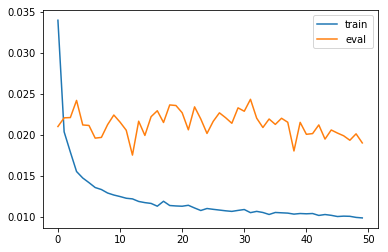

In [35]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

In [36]:
def inv2(testPredictML,test_X,test_y):
    # invert scaling for forecast
    inv_testPredictML = concatenate((test_X[:,:],testPredictML), axis=1)
    inv_testPredictML = scaler.inverse_transform(inv_testPredictML)
    testPredictML = inv_testPredictML[:,-1:]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_test = concatenate((test_X[:,:],test_y), axis=1)
    inv_test = scaler.inverse_transform(inv_test)
    testReal = inv_test[:,-1:]
    return testPredictML,testReal

In [37]:
# make a prediction
testPredictls1 = model1.predict(test_X)
testPredictls2 = model2.predict(test_X)


In [38]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

testPredictls1,testReal = inv2(testPredictls1,test_X,test_y)
testPredictls2,testReal = inv2(testPredictls2,test_X,test_y)

In [39]:
# calculate RMSE
rmse = sqrt(mean_squared_error(testReal, testPredictls1))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.250


In [40]:
# calculate RMSE
rmse = sqrt(mean_squared_error(testReal, testPredictls2))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.263


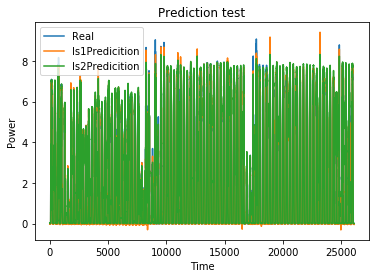

In [41]:
#真实值和预测值对比图
plt.plot(testReal,label='Real')
plt.plot(testPredictls1,label='ls1Predicition')
plt.plot(testPredictls2,label='ls2Predicition')
# plt.plot(testPredictM3,label='M3Predicition')

plt.title('Prediction test')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend()  

In [42]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: Error when checking : expected lstm_2_input to have 3 dimensions, but got array with shape (26090, 21)

# dense_model3 with activation,bias

In [ ]:
model3 = Sequential()
model3.add(Dense(units=64, input_shape = (13,),activation='sigmoid',name='layer1',use_bias = True))
model3.add(Dense(units=32,activation='sigmoid',name='layer2',use_bias = True))
model3.add(Dense(units=16,name='layer3',activation='sigmoid',use_bias = True))
model3.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model3.add(Dense(units=1,name='layer5'))
model3.compile(loss='mean_absolute_error',
              optimizer='rmsprop',
              metrics=['mae'])
history=model3.fit(x = train_x,y = train_y, validation_data = (eval_x,eval_y), epochs=50, batch_size=1000)
############################################################################################################

In [ ]:
########################################################################
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 结果对比

In [ ]:
################预测训练集和测试集####################
######### 模型 1 #########
trainPredictM1 = model1.predict(train_x)
testPredictM1 = model1.predict(test_x)
######### 模型 2 #########
trainPredictM2 = model2.predict(train_x)
testPredictM2 = model2.predict(test_x)
######### 模型 3 ##########
trainPredictM3 = model3.predict(train_x)
testPredictM3 = model3.predict(test_x)

############################## 反归一化 ##############################

###################### 训练集反归一化 #######################
######预测值 模型1 #######
inv_trainPredict1 = concatenate((train_x[:,:],trainPredictM1), axis=1)
inv_trainPredict1 = scaler.inverse_transform(inv_trainPredict1)
trainPredictM1 = inv_trainPredict1[:,-1:]

######预测值 模型2 #######
inv_trainPredict2 = concatenate((train_x[:,:],trainPredictM2), axis=1)
inv_trainPredict2 = scaler.inverse_transform(inv_trainPredict2)
trainPredictM2 = inv_trainPredict2[:,-1:]

######训练预测 模型3 #######
inv_trainPredict3 = concatenate((train_x[:,:],trainPredictM3), axis=1)
inv_trainPredict3 = scaler.inverse_transform(inv_trainPredict3)
trainPredictM3 = inv_trainPredict3[:,-1:]

###### 训练集真实值######
train_y = train_y.reshape((len(train_y), 1))
inv_train = concatenate((train_x[:,:],train_y), axis=1)
inv_train = scaler.inverse_transform(inv_train)
trainReal = inv_train[:,-1:]


######################## 测试集反归一化 ########################
###### 测试预测模型1 #######
inv_testPredict1 = concatenate((test_x[:,:],testPredictM1), axis=1)
inv_testPredict1 = scaler.inverse_transform(inv_testPredict1)
testPredictM1 = inv_testPredict1[:,-1:]

###### 测试预测模型2 #######
inv_testPredict2 = concatenate((test_x[:,:],testPredictM2), axis=1)
inv_testPredict2 = scaler.inverse_transform(inv_testPredict2)
testPredictM2 = inv_testPredict2[:,-1:]

###### 测试预测模型3 #######
inv_testPredict3 = concatenate((test_x[:,:],testPredictM3), axis=1)
inv_testPredict3 = scaler.inverse_transform(inv_testPredict3)
testPredictM3 = inv_testPredict3[:,-1:]

########测试集真实值############
test_y = test_y.reshape((len(test_y), 1))
inv_test = concatenate((test_x[:,:],test_y), axis=1)
inv_test = scaler.inverse_transform(inv_test)
testReal = inv_test[:,-1:]

#################### 计算训练集和测试集的平均根方误差####################
### 模型 1
trainScoreM1 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM1[:,0]))
print('Model1 ')
print('Train Score: %.2f RMSE' % (trainScoreM1))
testScoreM1 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM1[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM1))
### 模型 2
trainScoreM2 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM2[:,0]))
print('Model2 ')
print('Train Score: %.2f RMSE' % (trainScoreM2))
testScoreM2 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM2[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM2))
### 模型 3
trainScoreM3 = math.sqrt(mean_squared_error(trainReal[:,0], trainPredictM3[:,0]))
print('Model3 ')
print('Train Score: %.2f RMSE' % (trainScoreM3))
testScoreM3 = math.sqrt(mean_squared_error(testReal[:,0], testPredictM3[:,0]))
print('Test Score: %.2f RMSE' % (testScoreM3))

In [ ]:
#训练集和测试集 预测结果保存
predict_train_1A = pd.DataFrame(inv_train)
predict_train_1A.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']

predict_train_1A['1A_model1_predict'] = trainPredictM1
predict_train_1A['1A_model2_predict'] = trainPredictM2
predict_train_1A['1A_model3_predict'] = trainPredictM3

predict_train_1A.to_csv('../predict/predict_train_1A.csv',index=False)
#真实值和预测值对比图
plt.plot(trainReal,label='Real')
plt.plot(trainPredictM1,label='M1Predicition')
plt.plot(trainPredictM2,label='M2Predicition')
plt.plot(trainPredictM3,label='M3Predicition')

plt.title('Prediction train')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend() 

In [ ]:
#训练集和测试集 预测结果保存
predict_1A = pd.DataFrame(inv_test)
predict_1A.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
       'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']

predict_1A['1A_model1_predict'] = testPredictM1
predict_1A['1A_model2_predict'] = testPredictM2
predict_1A['1A_model3_predict'] = testPredictM3

predict_1A.to_csv('../predict/predict_1A.csv',index=False)
#真实值和预测值对比图
plt.plot(testReal,label='Real')
plt.plot(testPredictM1,label='M1Predicition')
plt.plot(testPredictM2,label='M2Predicition')
plt.plot(testPredictM3,label='M3Predicition')

plt.title('Prediction test')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.plot(y_rr_,label='rr')
# plt.plot(y_lasso_,label='lasso')
plt.legend() 

In [ ]:
# mse_test=np.sum((test_y - testPredict)**2)/ len(test_y)
# rmse_test=np.sqrt(mse_test)
# print("MSE:",mse_test)
# print("RMSE:",rmse_test)

画出例如2020年1月20号的预测图

In [ ]:
predict_1A.columns

In [ ]:
# from scipy.interpolate import spline
predict_1A[["Year","Month","Day","Hour","Minutes"]] = predict_1A[["Year","Month","Day","Hour","Minutes"]].astype("int")

#real_power_day = train_1.groupby('day')
# Day0120 = predict_1A[(predict_1A['Year'] == 2020) & (predict_1A['Month'] == 1) & (predict_1A['Day'] == 20)]
# day200120 = predict_1A.loc[predict_1A['Year'] == '2020',predict_1A['Month'] == '1',predict_1A['day'] == '20',:]
Day0120 = predict_1A.loc[(predict_1A['Year'] == 2020) & (predict_1A['Month'] == 1) & (predict_1A['Day'] == 20),:]
#real_power_day.set_index('time', inplace=False)
Real=Day0120.set_index('Hour', inplace=False)['1A Trina_power']
M1Predict=Day0120.set_index('Hour', inplace=False)['1A_model1_predict']
M2Predict=Day0120.set_index('Hour', inplace=False)['1A_model2_predict']
M3Predict=Day0120.set_index('Hour', inplace=False)['1A_model3_predict']

fig = plt.figure()
plt.plot(Real,label='Real')
plt.plot(M1Predict,label='M1Predicition')
plt.plot(M2Predict,label='M2Predicition')
plt.plot(M3Predict,label='M3Predicition')

plt.title('Prediction 2020-1-20')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
#ax = fig.add_subplot(1,1,1)
#ax.plot(real_power_day_)
# real_power_day_.plot()
#real_power_day_.set_axis(['00:15:00','06:15:00','12:15:00','18:15:00'])
#real_power_day_